# WDBC Data Sets Analysis

The following jupyter notebook provides summary of the analysis undertaken on the `WDBC` data set.

## Outline

* **Download** section covers initial file sourcing and import
* **Descriptive analysis** section focus on answering first two question concerned with descriptive statistics of `perimeter` feature and distribution characteristics of the `radius` variable
* **Modelling** section covers last element of assignment pertaining to classifier training and model development

## Download

Download available files.
 1. List available files from the website
 2. Create absolute url paths and download files to temp folder
*The snippet useful if re-running the netbook and saves hassle with sourcing raw data*

In [129]:
# Modules
# File download and storage
import os
import sys
import tempfile
from urllib.request import urlopen
from urllib.request import urlretrieve
from urllib.parse import urljoin
from bs4 import BeautifulSoup
# Data manipulation
import pandas as pd
# Gadgets
from termcolor import colored # Coloured console output
import humanize # Human readable units (useful for file sizes, etc.)
from IPython.display import display, HTML # Common aproach to keep nice layout and avoid printing index
import seaborn as sns # Charts

/Users/huski/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



In [2]:
# Download relevant files to temp storage
tmp_fld = tempfile.mkdtemp(suffix='wdbc_data', prefix='tmp')
url_dta_fld = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/'
site = urlopen(url_dta_fld)
content = site.read()
soup = BeautifulSoup(content, "html.parser")
list_urls = soup.find_all('a')
# Download desired files
dta_fls = []
for url in list_urls:
    asst_url = urljoin(url_dta_fld,url['href'])
    # Names are useful for the attribute information
    if asst_url.endswith(('.data', '.names')):
        dta_fls.append(os.path.join(tmp_fld, asst_url.split('/')[-1]))
        print(asst_url)
        urlretrieve(url=asst_url, filename=dta_fls[-1])
        print(colored('Saved: ' + dta_fls[-1], 'green'))

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpjhtnd_lvwdbc_data/breast-cancer-wisconsin.data
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpjhtnd_lvwdbc_data/breast-cancer-wisconsin.names
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpjhtnd_lvwdbc_data/wdbc.data
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpjhtnd_lvwdbc_data/wdbc.names
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data
Saved: /var/folders/7x/kwc1y_l96t55_rwlv35mg8xh0000gn/T/tmpjhtnd_lvwdbc_data/wpbc.data
https://archive.ics.uci.e

### Available files
_Includes summary of .names files_

In [41]:
dta_fls_info = pd.DataFrame(
    {'file' : list(map(os.path.basename, dta_fls)),
     'size' : [humanize.naturalsize(os.path.getsize(fle)) for fle in dta_fls],
     'lines' : list(map(lambda fle: sum(1 for _ in fle), dta_fls))
    })
display(HTML(dta_fls_info.to_html(index=False)))

file,lines,size
breast-cancer-wisconsin.data,98,19.9 kB
breast-cancer-wisconsin.names,99,5.7 kB
wdbc.data,79,124.1 kB
wdbc.names,80,4.7 kB
wpbc.data,79,44.2 kB
wpbc.names,80,5.7 kB


### Import

In [37]:
# --- Do not run ---
stdout_nms = []
for fle in dta_fls:
    if fle.endswith('names'):
        stdout_nms.append(os.popen("cat " + fle).read())
# --- Do not run ---
# stdout_nms
# The one coule analyse *.names files to pick relevant list but the .names file format and number of variables
# does not justify that effort.

#### Conveniance function (pd sample)
Simple conveniance function providing data frame preview by taking head/tail and wee sample in for the middle. More useful than changing defult printing options, IMHO.

In [69]:
def pd_preview (data_frame, sample_size = 3, tail_lines = 1, head_lines = 1):
    # Generate data frames to append
    df_head = data_frame.head(n = head_lines)
    df_tail = data_frame.tail(n = tail_lines)
    df_smpl = data_frame.sample(n = sample_size)
    # Append
    df_preview = df_head.append([df_smpl, df_tail])
    return df_preview

### Read

Read data sets, including **core** wdbc data set as well as other data set available in the folder (for the evenual further 

In [73]:
dta_brst_cncr = pd.read_csv(filepath_or_buffer=dta_fls[0],
                            names=['id_num', 
                                   'clump_thickness',
                                   'uniformity_cell_size',
                                   'uniformity_cell_shape',
                                   'marginal_adhesion',
                                   'single_epithelial_cell_size',
                                   'bare_nuclei',
                                   'bland_chromatin',
                                   'normal_nucleoli',
                                   'mitoses',
                                   'class'])
preview(dta_brst_cncr)

,id_num,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
430,1276091,1,3,1,1,2,1,2,2,1,2
192,1212232,5,1,1,1,2,1,2,1,1,2
348,832226,3,4,4,10,5,1,3,3,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


This is **core** data set, initial analysis will be conducted on this data set.

The column names are derived as per the information available in wdbc.names. `*_lsrgst` columns reflect "worst" or largest (mean of the three largest values)" metric as per the [available documentation](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

In [98]:
# Col names
col_nms = ['ID', 'diagnosis', 'radius', 'texture', 'perimeter', 'area',
           'smoothness', 'compactness', 'concavity', 'concave_points',
           'symmetry', 'fractal_dimension', 'radius_se', 'texture_se', 
           'perimeter_se', 'area_se', 'smoothness_se', 
           'compactness_se', 'concavity_se', 'concave_points_se', 
           'symmetry_se', 'fractal_dimension_se', 
           'radius_lrgst', 'texture_lrgst', 'perimeter_lrgst',
           'area_lrgst', 'smoothness_lrgst', 
           'compactness_lrgst', 'concavity_lrgst', 
           'concave_points_lrgst', 'symmetry_lrgst', 
           'fractal_dimension_lrgst']


In [99]:
dta_wdbc = pd.read_csv(filepath_or_buffer=dta_fls[2],
                      names=col_nms)
# US ID as index
dta_wdbc.set_index(['ID'], inplace=True)

In [100]:
preview(dta_wdbc)

,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,...,radius_lrgst,texture_lrgst,perimeter_lrgst,area_lrgst,smoothness_lrgst,compactness_lrgst,concavity_lrgst,concave_points_lrgst,symmetry_lrgst,fractal_dimension_lrgst
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.26540,0.4601,0.11890
8510426,B,13.54,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,...,15.110,19.26,99.70,711.2,0.14400,0.17730,0.2390,0.12880,0.2977,0.07259
8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.620,15.54,87.40,577.0,0.09616,0.11470,0.1186,0.05366,0.2309,0.06915
91858,B,11.75,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.04440,0.1598,...,13.500,27.98,88.52,552.3,0.13490,0.18540,0.1366,0.10100,0.2478,0.07757
92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039


# Descriptive analysis

The following section provides initial descriptive analysis as well as introduces some addittional metrics. The assigned deliverables pertain to:
1. Computing mean, median and standard deviation of `perimeter` feature
2. Normal distribution test for `radius` variable

## *Perimeter* feature - descriptive analysis

Following the provided documentation, the `perimeter` feature is represented in the data set with use of the following variables.

In [101]:
# Case insenstive search is not required but does it's good practice
print("\n".join(s for s in col_nms if 'perimeter' in s.lower()))

perimeter
perimeter_se
perimeter_lrgst


In [110]:
# Compute required statistics using pandas df.agg
dta_smry_perimeter = dta_wdbc['perimeter'].agg(['mean', 'median', 'std'])
dta_smry_perimeter

mean      91.969033
median    86.240000
std       24.298981
Name: perimeter, dtype: float64

#### Answer

In [122]:
print('The average value of the perimeter feature is ' + str(round(dta_smry_perimeter['mean'], 2)) + 
      ', median ' + str(round(dta_smry_perimeter['median'], 2)) + ' and standard deviation is ' +
     str(round(dta_smry_perimeter['std'], 2)) + '.')

The average value of the perimeter feature is 91.97, median 86.24 and standard deviation is 24.3.


##### Box Plot

*The desired dispersion can be convenintely visualised with use of a box plot, the figure below addittionaly overplots 

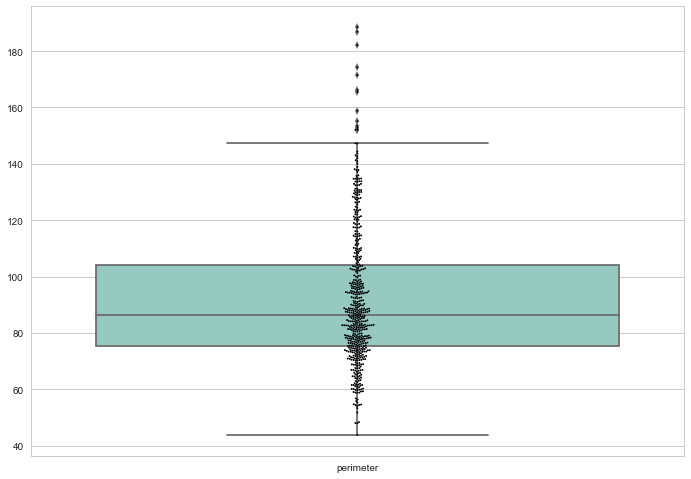

In [152]:
# Force bigger seaborn figure size: https://stackoverflow.com/a/47955814/1655567
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=dta_wdbc[['perimeter']], palette="Set3")
sns.swarmplot(data=dta_wdbc[['perimeter']], size=1, edgecolor="black", linewidth=.9)